In [86]:
import pandas as pd
import numpy as np
import sklearn as sk
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors
# from pymuller import muller

In [2]:
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

def convert_state_stfips(state):
    try:
        return state_to_stfips[state]
    except:
        return np.nan
    
def convert_abbr_stfips(abbr):
    try:
        return abbr_to_stfips[abbr]
    except:
        return np.nan

In [3]:
metadata = pd.read_csv("../variant_data/metadata.tsv", sep="\t", parse_dates = ["Collection date", "Submission date"])
# print(metadata.columns)
# metadata = metadata[["Accession ID", \
#                    "Collection date", \
#                    "Submission date", \
#                    "Location", \
#                    "Additional location information", \
#                    "Sequence length", \
#                    "Host", \
#                    "AA Substitutions", \
#                    "Is reference?", \
#                    "Pango lineage"]]
def get_nth_slash(row, n):
    try:
        return row.split("/")[n].strip()
    except:
        return np.nan
    
for i in range(4):
    metadata[f"Location_{i}"] = metadata["Location"].apply(lambda row: get_nth_slash(row, i))
metadata = metadata.rename(columns={"Location_1":"country", "Location_2":"state"})
metadata = metadata[metadata["country"] == "USA"]
metadata["alias"] = metadata["Virus name"].apply(lambda row: "/".join(row.split("/")[2:]))

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ncbi = pd.read_csv("../variant_data/sequences.csv", parse_dates=["Release_Date"])

ncbi["is_USA"] = ncbi["Geo_Location"].apply(lambda row: True if "USA" in str(row) else False)
ncbi = ncbi[ncbi.is_USA]
all_usa_ncbi = ncbi.shape
print(ncbi.shape[0], "NCBI from the US")

ncbi = ncbi.dropna(subset=["GenBank_Title"])
ncbi["alias"] = ncbi["GenBank_Title"].apply(lambda row: row.split(",")[0].split(" isolate ")[-1].split("USA/")[-1])

print(ncbi.columns)
ncbi = ncbi[ncbi.alias.isin(list(set(ncbi.alias) - set(metadata.alias)))]
only_ncbi = ncbi.shape
ncbi = ncbi[~ncbi.USA.isna()][["Collection_Date", "Pangolin", "USA"]]
ncbi.columns = ["date", "variant", "state"]
ncbi.date = pd.to_datetime(ncbi.date)
ncbi.state = ncbi.state.apply(convert_abbr_stfips)
ncbi = ncbi.dropna()
print(all_usa_ncbi[0] - only_ncbi[0], "in NCBI and GISAID")
print(only_ncbi[0], "in NCBI only")

metadata = metadata[["Collection date", "Pango lineage", "state"]]
metadata.columns = ["date", "variant", "state"]
metadata.date = pd.to_datetime(metadata.date)
metadata.state = metadata.state.apply(convert_state_stfips)
metadata = metadata.dropna()

141378 NCBI from the US
Index(['Accession', 'SRA_Accession', 'Release_Date', 'Pangolin', 'Species',
       'Genus', 'Molecule_type', 'Length', 'Sequence_Type', 'Nuc_Completeness',
       'Genotype', 'Segment', 'Geo_Location', 'USA', 'Host',
       'Isolation_Source', 'Collection_Date', 'BioSample', 'GenBank_Title',
       'is_USA', 'alias'],
      dtype='object')
129952 in NCBI and GISAID
11426 in NCBI only


In [5]:
variants = pd.concat([metadata, ncbi], ignore_index=True)
variants = variants[variants.date >= "2020-02-27"] #First day with >10 samples
vocs = ['B.1.1.7',
        'B.1.351',
        'P.1',
        'B.1.617.1',
        'B.1.617.2',
        'B.1.427',
        'B.1.429',
        'B.1.526',
        'B.1.526.1',
        'B.1.526.2']
variants.variant = variants.variant.apply(lambda row: row if row in vocs else "other")

In [32]:
adjacency = [("other", i) for i in vocs]
adjacency = pd.DataFrame.from_records(adjacency, columns = ["Parent", "Identity"])

In [56]:
variants.groupby(["date", "variant"]).count().reset_index()

,date,variant,state
0,2020-02-27,other,11
1,2020-02-28,other,28
2,2020-02-29,other,41
3,2020-03-01,other,212
4,2020-03-02,other,50
...,...,...,...
1720,2021-05-11,P.1,2
1721,2021-05-11,other,2
1722,2021-05-12,B.1.1.7,2
1723,2021-05-13,B.1.1.7,1


In [93]:
variants

,date,variant,state
0,2020-03-02,other,53
1,2020-03-21,other,53
2,2020-03-21,other,53
3,2020-03-21,other,53
4,2020-03-21,other,53
...,...,...,...
452067,2020-03-13,other,53
452068,2020-03-13,other,53
452069,2020-03-13,other,53
452070,2020-03-13,other,53


In [131]:
def plot_state_variants(state, ax, rolling=False):
    
    variant_names = variants.variant.unique()
    NUM_COLORS = len(variant_names)

    cm = plt.get_cmap('terrain')
    cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS)][::-1])
    
    if state in ["US", "USA"]:
        ny = variants.copy()
    else:    
        ny = variants[variants.state == state].sort_values("date")
    ny = ny.groupby(["date", "variant"]).count().reset_index()
    ny = ny.pivot(index="date", columns="variant", values="state").fillna(0)
#     ny = ny.resample("7D").sum()
    # ny = ny.reset_index(drop=True).reset_index().melt(id_vars="index")
    # ny.columns = ["Generation", "Identity", "Population"]
    # ny = ny.sort_values("Generation")
#     fig, ax = plt.subplots(figsize=(10,8))
    if rolling:
        data = ny.copy().rolling(7).mean()
    else:
        data = ny.resample("7D").sum().copy()
    data.other = data.other.replace(0, 0.001) 
    data = data.divide(data.sum(axis=1), axis=0)
    for column in set(variant_names) - set(data.columns):
        data[column] = 0
    data = data[variant_names[::-1]]
    ax.stackplot(data.index, data.T, labels=data.columns)
    ax.legend(loc="upper left")   
    return data

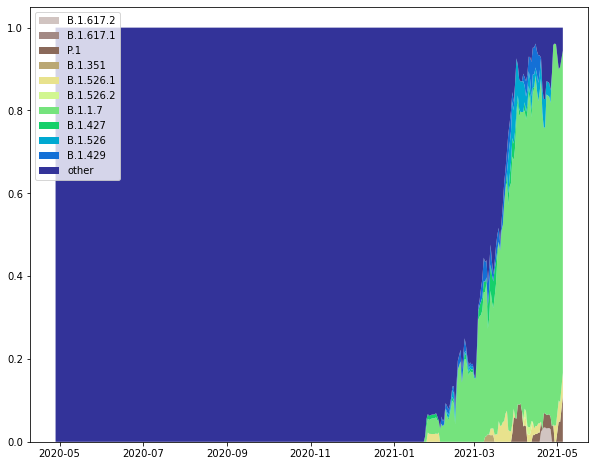

In [132]:
fig, ax = plt.subplots(figsize=(10,8))
data = plot_state_variants("01", ax, rolling=1)

In [ ]:
data

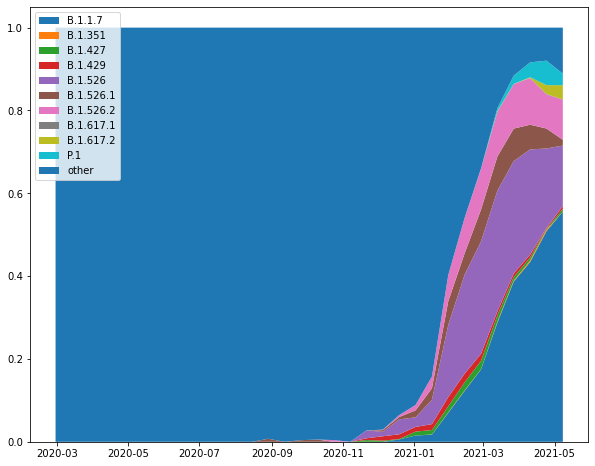

In [75]:
ny = variants[variants.state == "36"].sort_values("date")
ny = ny.groupby(["date", "variant"]).count().reset_index()
ny = ny.pivot(index="date", columns="variant", values="state").fillna(0)
ny = ny.resample("14D").sum()
# ny = ny.reset_index(drop=True).reset_index().melt(id_vars="index")
# ny.columns = ["Generation", "Identity", "Population"]
# ny = ny.sort_values("Generation")
fig, ax = plt.subplots(figsize=(10,8))
data = ny.copy() #.rolling(7).mean()
data = data.divide(data.sum(axis=1), axis=0)
ax.stackplot(data.index, data.T, labels=data.columns)
ax.legend(loc="upper left")

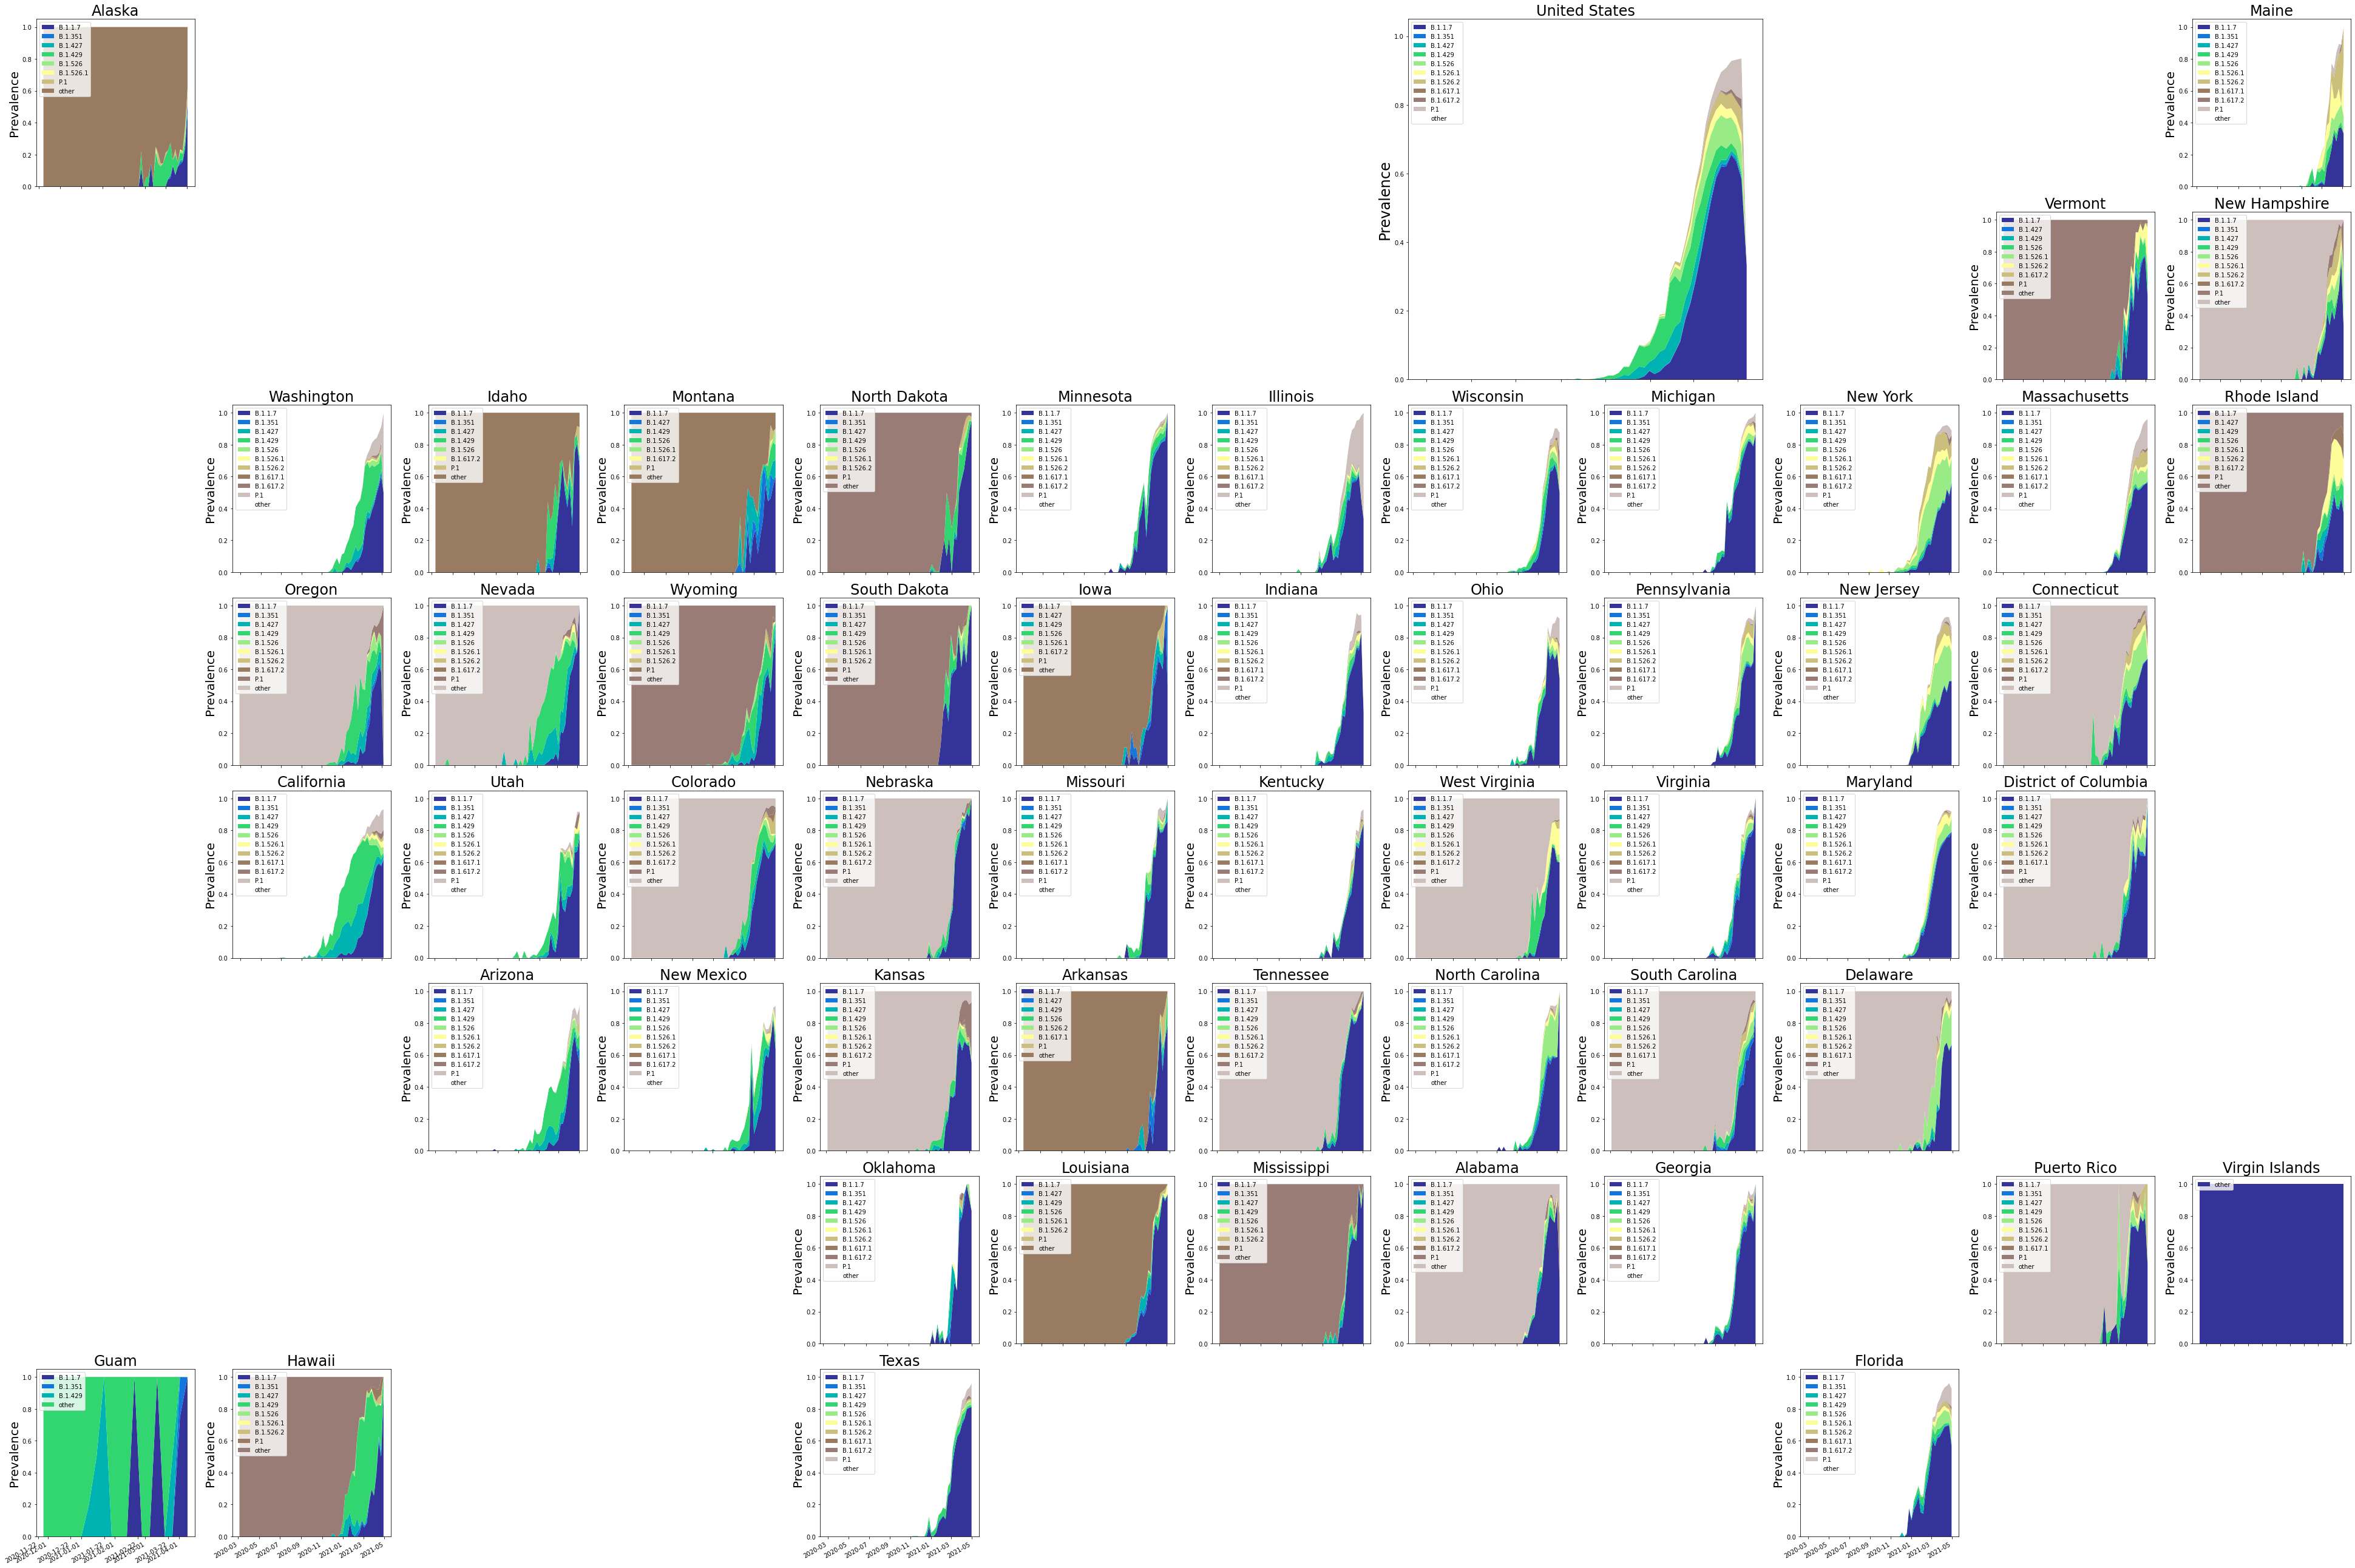

In [117]:
def get_us_grid():
    stat_notes = "/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/notebooks/"
    state_hhs = pd.read_csv(stat_notes+'../misc_data/state_hhs_map.csv',usecols=[0,1,2,3],names=['sFIPS','HHS','state','StateName'],dtype=str)
    state_hhs['HHS'] = state_hhs.HHS.apply(lambda x: 'HHS Region {}'.format(x))
    us_df = pd.read_csv(stat_notes+'../misc_data/us_subplot_grid.csv')
    
    return us_df

us_df = get_us_grid()
fig = plt.figure(figsize=(54,36)) 
gs = fig.add_gridspec(8,12)

us_ax = fig.add_subplot(gs[0:2, 7:9])
plot_state_variants("US", us_ax)
# state_dfs["US"].plot(ax=us_ax, legend=False)
# state_variant_prevalence.mean(axis=1).loc["2021-01-01":"2021-05-10"].plot(ax=us_ax, color="k", linestyle="--", alpha=0.6)    
us_ax.set_title("United States", fontsize=24)
us_ax.set_ylabel("Prevalence", fontsize=24)
us_ax.set_ylim(0,1.05)

for r in range(8):
    for c in range(12):
        mask = (us_df.Row==r)&(us_df.Column==c)

        if len(us_df[mask])==0: # and not unseen_regions:
            pass
        else:
            ax = fig.add_subplot(gs[r,c])
            state = us_df[mask]['Name'].values[0]
            fips = state_to_stfips[state]
            plot_state_variants(fips, ax)
            
#             state_variant_prevalence[state_to_stfips[state]].loc["2021-01-01":"2021-05-10"].plot(ax=ax, color="k", linestyle="--", alpha=0.6, label="B117 Adaptive Prevalence")
#             abbr = state_to_state_abbr[state]
#             try:
#                 state_dfs[abbr].plot(ax=ax)
#             except:
#                 ax.set_visible(False)
#                 continue
            ax.set_title(state, fontsize=24)
            ax.set_ylabel("Prevalence", fontsize=20)
            ax.set_ylim(0,1.05)
#             h1, l1 = ax.get_legend_handles_labels()
#             ax.get_legend().remove()
        
fig.autofmt_xdate()
# fig.legend(h1, l1, bbox_to_anchor=(0.45, 0.98), fontsize=24)
plt.tight_layout()
# plt.savefig(plot_dir / f"all_strains_summary_grid.png", dpi=100, bbox_inches="tight")

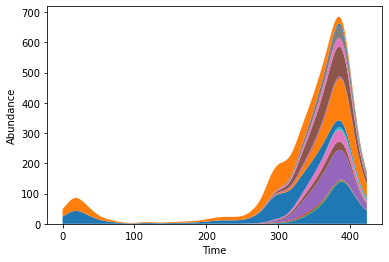

In [34]:
"""
From https://github.com/boaz85/pymuller/blob/master/pymuller/logic.py
"""
def _get_strains_ordering(adjacency_df):

    children_by_parent = adjacency_df.groupby('Parent')['Identity'].apply(lambda x: list(sorted(x)))

    def get_inner_order(identity):

        children_identities = children_by_parent.get(identity, [])

        if len(children_identities) == 0:
            return [identity, identity]

        inner = [get_inner_order(c) for c in children_identities]
        return [identity] + sum(inner, []) + [identity]

    order = []

    identities = list(set(adjacency_df['Identity'].values) | set(adjacency_df['Parent'].values))

    for strain in sorted(identities):
        if strain not in order:
            order += get_inner_order(strain)

    return np.array(order)


def _get_strains_ordering_old(adjacency_df):

    children_by_parent = adjacency_df.groupby('Parent')['Identity'].apply(lambda x: list(sorted(x)))

    def get_inner_order(identity):

        children_identities = children_by_parent.get(identity, [])

        if len(children_identities) == 0:
            return [identity, identity]

        return [identity] + sum([get_inner_order(c) for c in children_identities], []) + [identity]

    order = []

    for strain in sorted(adjacency_df['Identity'].unique()):
        if strain not in order:
            order += get_inner_order(strain)

    return np.array(order)

def _get_y_values(populations_df, adjacency_df, smoothing_std):

    ordering = _get_strains_ordering(adjacency_df)
    population_size_max = populations_df.groupby('Generation')['Population'].sum().max()
    generations = populations_df['Generation'].max() - populations_df['Generation'].min()

    pivot = populations_df.pivot(index='Generation', columns='Identity', values='Population').sort_index()
    pivot = pivot.rolling(generations, 1, True, 'gaussian').mean(std=smoothing_std).clip(0, population_size_max)

    Y = pivot[ordering] / 2

    # Avoid middle lines. Double leaf clones.
    keep = [0]

    for i, c in enumerate(Y.columns[1:], 1):
        if c == Y.columns[i - 1]:
            Y.iloc[:, i] *= 2
            keep.pop()

        keep.append(i)

    return Y.iloc[:, keep]


def muller_plot(populations_df_orig, adjacency_df_orig, color_by=None, colormap='terrain', colorbar=True, background_strain=True,
                 smoothing_std=10, normalize=False, ax=None, click_callback=None):

    populations_df = populations_df_orig.copy()
    adjacency_df = adjacency_df_orig.copy()
    
    if normalize:
        populations_df['Population'] = populations_df.groupby('Generation')['Population'].transform(lambda x:
                                                                                                    x / x.sum())

    x = populations_df['Generation'].unique()
    y_table = _get_y_values(populations_df, adjacency_df, smoothing_std)

    final_order = y_table.columns.values
    Y = y_table.to_numpy().T

#     if color_by is None:
#         ordering = _get_strains_ordering_old(adjacency_df)
#         print(ordering)
#         normed = (ordering - ordering.min()) / (ordering.max() - ordering.min())
#         colors = matplotlib.cm.terrain(normed)
#     else:
#         cmap = plt.get_cmap(colormap)
#         color_by = color_by.copy()
#         ordered_colors = color_by.loc[final_order]
#         norm = matplotlib.colors.Normalize(vmin=np.min(ordered_colors), vmax=np.max(ordered_colors))
#         colors = cmap(norm(ordered_colors.values))

#     if background_strain:
#         colors[0] = colors[-1] = [1, 1, 1, 1]

    if ax is None:
        fig, ax = plt.subplots()

    else:
        fig = ax.figure if hasattr(ax, 'figure') else ax.fig

    ax.stackplot(x, Y) #, colors=colors)

#     if colorbar:
#         cax = fig.add_axes([0.92, 0.13, 0.02, 0.7])
#         cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
#         cb.set_label(color_by.name)

    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency' if normalize else 'Abundance')

    plt.sca(ax)

    
muller_plot(ny, adjacency)

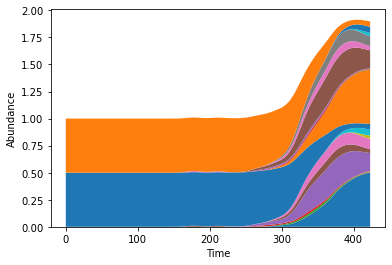

In [ ]:
  normed = (ordering - ordering.min()) / (ordering.max() - ordering.min())
￼    colors = matplotlib.cm.terrain(normed)

In [212]:
color_by = pd.DataFrame.from_records([(5, "other")] + [(ix+7, vocs[ix]) for ix in range(len(vocs))]).set_index(1)
color_by

,0
1,
other,5
B.1.1.7,7
B.1.351,8
P.1,9
B.1.617.1,10
B.1.617.2,11
B.1.427,12
B.1.429,13
B.1.526,14


In [209]:
import matplotlib

In [213]:
cmap = plt.get_cmap("terrain")
norm = matplotlib.colors.Normalize(vmin=np.min(color_by), vmax=np.max(color_by))
colors = cmap(norm(color_by.values))
colors

array([[[0.2       , 0.2       , 0.6       , 1.        ]],

       [[0.        , 0.66078431, 0.81764706, 1.        ]],

       [[0.08235294, 0.81647059, 0.41647059, 1.        ]],

       [[0.45882353, 0.89176471, 0.49176471, 1.        ]],

       [[0.81960784, 0.96392157, 0.56392157, 1.        ]],

       [[0.90980392, 0.88454902, 0.55129412, 1.        ]],

       [[0.72941176, 0.65364706, 0.45388235, 1.        ]],

       [[0.54117647, 0.41270588, 0.35223529, 1.        ]],

       [[0.63921569, 0.53819608, 0.51654902, 1.        ]],

       [[0.81960784, 0.76909804, 0.75827451, 1.        ]],

       [[1.        , 1.        , 1.        , 1.        ]]])

ValueError: array([[0.        , 0.66078431, 0.81764706, 1.        ]]) does not look like a color arg

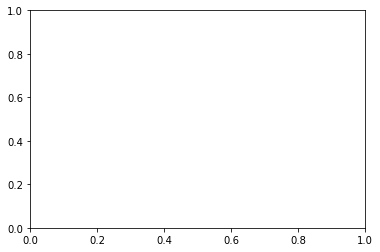

In [215]:
muller(ny, adjacency, color_by, background_strain=False)